Weather Forecast

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import numpy as np
from torchvision.datasets.utils import download_url
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from collections import OrderedDict

DataSource 

We will be using data from  Max-Planck-Institute for Biogeochemistry at https://www.bgc-jena.mpg.de/wetter/ and as per documentation at https://www.bgc-jena.mpg.de/wetter/Weatherstation.pdf we get the following metadata about Weather Data table

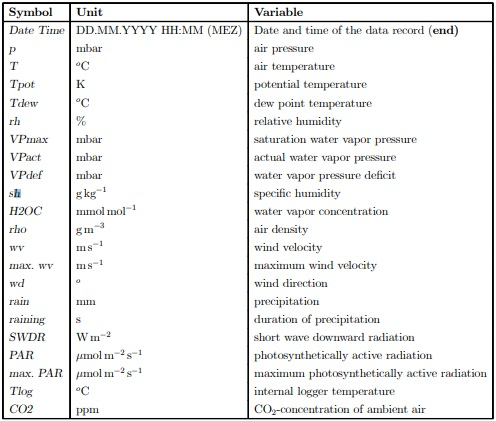

In [51]:
dataset_url = "https://github.com/amandatta16/WeatherPrediction/blob/main/Dataset/compiled_2009_2016.csv.zip?raw=true"
download_url(dataset_url, './data','compiled_2009_2016.csv.zip' )
zip_file = ZipFile('./data/compiled_2009_2016.csv.zip')
zip_file.extractall()
df = pd.read_csv('./data/compiled_2009_2016.csv.zip')
df.head()

Using downloaded and verified file: ./data/compiled_2009_2016.csv.zip


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


If we closely monitor the data above, in column Date Time, data is getting recorded after timestamp of 10 minutes that means sensor records data 6 times in an hour.
That means in a day or 24 hours 24 * 6 = 144 readings in a day.

Now we will use past 4 days readings or 144 * 4 = 576 timestamp to predict data of next day that means after 24 hours = 24 * 6 = 144 readings

so for a input variable of 576 reading the target label will stand at 576 + 144 = 720 readings
so 
for each i
    X[i+0:i+576] should predict Y[i+720]

Preparing dataset


In [52]:
od = OrderedDict()
od["p (mbar)"] = "Pressure"
od["VPmax (mbar)"] = "Saturation vapor pressure"
od["VPdef (mbar)"] = "Vapor pressure deficit"
od["sh (g/kg)"] = "Specific humidity"
od["rho (g/m**3)"] = "Airtight"
od["wv (m/s)"] = "Wind speed"
od["T (degC)"] = "Temperature"



Selecting the features putting most impact


In [53]:

input_features = [i for i in od]
features = df[input_features]
features.index = df["Date Time"]
features.head()

,p (mbar),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),T (degC)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,3.33,0.22,1.94,1307.75,1.03,-8.02
01.01.2009 00:20:00,996.57,3.23,0.21,1.89,1309.80,0.72,-8.41
01.01.2009 00:30:00,996.53,3.21,0.20,1.88,1310.24,0.19,-8.51
01.01.2009 00:40:00,996.51,3.26,0.19,1.92,1309.19,0.34,-8.31
01.01.2009 00:50:00,996.51,3.27,0.19,1.92,1309.00,0.32,-8.27


Visualizing Data

we will plot Temperatue on Y axis against each feature plotted at x axis over entire timeframe 

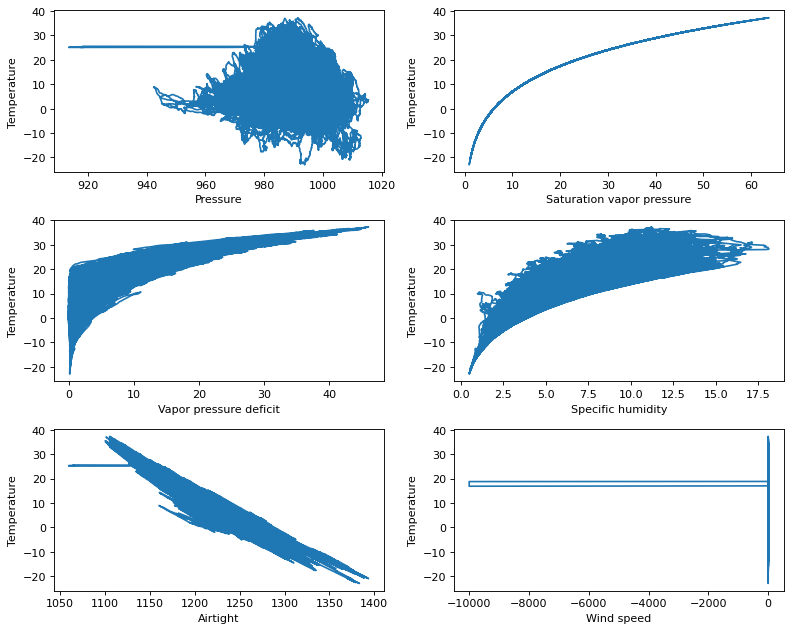

In [54]:
def temperatureToFeatureVisualization(df):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    tempKey = "T (degC)"
    i = 0
    length = len(input_features) - 1
    while i < length:
        key = input_features[i]
        y = df["T (degC)"].to_list()
        x = df[key].to_list()
        axes[i // 2, i % 2].plot(x, y)
        axes[i // 2, i % 2].set(xlabel=od[key], ylabel=od[tempKey])
        i += 1
    fig.tight_layout()
    plt.show()


temperatureToFeatureVisualization(df)

Scale data using minmaxscaler

as we are going to feed the input features to deep learning
model we need to make sure that features value range are uniform so that gradient descent algorithm has smooth descent.

In [55]:
input_features = []
for i in od:
  if i != "T (degC)":
    input_features.append(i)
features = df[input_features]
target = df[["T (degC)"]]
target.index = df["Date Time"]
features.index = df["Date Time"]

print(features.shape[0])
print(target.shape[0])
print(df.head())
print(features.head())
print(target.head())


420551
420551
             Date Time  p (mbar)  T (degC)  ...  wv (m/s)  max. wv (m/s)  wd (deg)
0  01.01.2009 00:10:00    996.52     -8.02  ...      1.03           1.75     152.3
1  01.01.2009 00:20:00    996.57     -8.41  ...      0.72           1.50     136.1
2  01.01.2009 00:30:00    996.53     -8.51  ...      0.19           0.63     171.6
3  01.01.2009 00:40:00    996.51     -8.31  ...      0.34           0.50     198.0
4  01.01.2009 00:50:00    996.51     -8.27  ...      0.32           0.63     214.3

[5 rows x 15 columns]
                     p (mbar)  VPmax (mbar)  ...  rho (g/m**3)  wv (m/s)
Date Time                                    ...                        
01.01.2009 00:10:00    996.52          3.33  ...       1307.75      1.03
01.01.2009 00:20:00    996.57          3.23  ...       1309.80      0.72
01.01.2009 00:30:00    996.53          3.21  ...       1310.24      0.19
01.01.2009 00:40:00    996.51          3.26  ...       1309.19      0.34
01.01.2009 00:50:00    996.

In [56]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
x = [i for i in od]
whole = scaler1.fit_transform(df[x].values)
features = scaler2.fit_transform(features.values)
target = scaler3.fit_transform(target.values)
print(len(features))
print(len(target))

420551
420551


In [57]:
split_fraction = 0.815
train_split = int(split_fraction * len(features))
train_split

342749

In [58]:
x_train = features[0 : train_split - 1]
x_val = features[train_split:]
y_train = target[0 : train_split - 1]
y_val = target[train_split:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

print(whole)
print("#"*100)
print(y_train)
print("#"*100)
print(x_train)
print("#"*100)
print(y_val)
print("#"*100)
print(x_val)

(342748, 6) (342748, 1)
(77802, 6) (77802, 1)
[[0.81493857 0.03788602 0.00478157 ... 0.74321291 0.99726153 0.24863161]
 [0.81542998 0.03629417 0.00456423 ... 0.74934898 0.99723061 0.24216288]
 [0.81503686 0.0359758  0.00434688 ... 0.75066599 0.99717776 0.24050423]
 ...
 [0.84737101 0.06192295 0.03368833 ... 0.68526445 0.99726651 0.329242  ]
 [0.84727273 0.05587393 0.02738535 ... 0.70073932 0.9973074  0.31149444]
 [0.84737101 0.05284941 0.02260378 ... 0.70918016 0.99728147 0.30170841]]
####################################################################################################
[[0.24863161]
 [0.24216288]
 [0.24050423]
 ...
 [0.91524299]
 [0.91457953]
 [0.91640405]]
####################################################################################################
[[0.81493857 0.03788602 0.00478157 0.08167896 0.74321291 0.99726153]
 [0.81542998 0.03629417 0.00456423 0.07884288 0.74934898 0.99723061]
 [0.81503686 0.0359758  0.00434688 0.07827567 0.75066599 0.99717776]
 ...
 [0.68

create data loaders

we need custom dataset for LSTM which uses seq of readings too


In [59]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, xSequenceLength, ySequenceLength):
        self.X = X
        self.y = y
        self.xSequenceLength = xSequenceLength
        self.ySequenceLength = ySequenceLength

    def __len__(self):
        return self.X.__len__() - (self.ySequenceLength)

    def __getitem__(self, index):
        #if len(self.X) > (index+self.xSequenceLength) and len(self.y) > (index+self.ySequenceLength-1):
        print("len(self.X) =",len(self.X), "index =", index, "|", "index :", index, " + ", "self.xSequenceLength :",self.xSequenceLength, " = ", (index+self.xSequenceLength), "| len(self.y) =", len(self.y), "(index+self.ySequenceLength-1)", "| index :", index, " + ", "self.ySequenceLength-1 :", self.ySequenceLength-1, " = ", (index+self.ySequenceLength-1))
        return ((self.X[index:index+self.xSequenceLength]), (self.y[index+self.ySequenceLength-1]))

In [60]:
oneDayReading = 144
xSequenceLength = oneDayReading * 4
ySequenceLength = xSequenceLength + oneDayReading



for x in range(ySequenceLength):
    if x == xSequenceLength - 1:
        print("*************************")
    print(x_train[x], "==", y_train[x])

[0.81493857 0.03788602 0.00478157 0.08167896 0.74321291 0.99726153] == [0.24863161]
[0.81542998 0.03629417 0.00456423 0.07884288 0.74934898 0.99723061] == [0.24216288]
[0.81503686 0.0359758  0.00434688 0.07827567 0.75066599 0.99717776] == [0.24050423]
[0.81484029 0.03677173 0.00412954 0.08054453 0.74752312 0.99719272] == [0.24382153]
[0.81484029 0.03693091 0.00412954 0.08054453 0.74695441 0.99719072] == [0.24448499]
[0.81474201 0.03788602 0.00412954 0.08281339 0.74354216 0.99717975] == [0.24813402]
[0.81474201 0.03963706 0.00391219 0.08735111 0.73701697 0.99717676] == [0.25526621]
[0.81474201 0.03963706 0.00412954 0.08678389 0.7370469  0.99717776] == [0.25526621]
[0.81474201 0.03836358 0.00456423 0.0833806  0.74147685 0.99718673] == [0.25045613]
[0.81503686 0.03629417 0.00478157 0.07827567 0.74949864 0.99721765] == [0.24183115]
[0.81592138 0.03486151 0.00478157 0.07543959 0.75485648 0.99720369] == [0.2363576]
[0.81592138 0.03454314 0.00456423 0.07430516 0.75668233 0.99718374] == [0.234

In [61]:


train_dataset = TimeseriesDataset(x_train, y_train, xSequenceLength, ySequenceLength)
val_dataset = TimeseriesDataset(x_val, y_val, xSequenceLength, ySequenceLength)

batch_size = 256

train_loader = DataLoader(train_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, drop_last=True)
#test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [62]:
dataiter = iter(train_loader)
dataiterVal = iter(val_loader)
sample_x, sample_y = dataiter.next()
sample_x_val, sample_y_val = dataiter.next()
print(sample_x.shape, sample_y.shape)
print("here")
print(sample_x[0], "==", sample_y[0])
print("here")
print(sample_x_val.shape, sample_y_val.shape)

len(self.X) = 342748 index = 0 | index : 0  +  self.xSequenceLength : 576  =  576 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 0  +  self.ySequenceLength-1 : 719  =  719
len(self.X) = 342748 index = 1 | index : 1  +  self.xSequenceLength : 576  =  577 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 1  +  self.ySequenceLength-1 : 719  =  720
len(self.X) = 342748 index = 2 | index : 2  +  self.xSequenceLength : 576  =  578 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 2  +  self.ySequenceLength-1 : 719  =  721
len(self.X) = 342748 index = 3 | index : 3  +  self.xSequenceLength : 576  =  579 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 3  +  self.ySequenceLength-1 : 719  =  722
len(self.X) = 342748 index = 4 | index : 4  +  self.xSequenceLength : 576  =  580 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 4  +  self.ySequenceLength-1 : 719  =  723
len(self.X) = 342748 index = 5 | index : 5  +  self.xSe

Creating Model

In [63]:
class WeatherNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(WeatherNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, output_size)
        
        
    def forward(self, x, hidden):
        x = x.float() 
        batch_size = x.size(0)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = (lstm_out[:, xSequenceLength-1, :])
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden


initialize model

In [64]:
input_size = 6
output_size = 1
hidden_dim = 64
n_layers = 1
model = WeatherNet(input_size, output_size, hidden_dim, n_layers)
print(model)

WeatherNet(
  (lstm): LSTM(6, 64, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [65]:
lr=0.005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print(model.parameters())


<generator object Module.parameters at 0x7f938544a9d0>


Start training

In [66]:
epochs = 1#3
counter = 0
print_every = 1000
clip = 5
valid_loss_min = np.Inf

model.train()
history = []
for i in range(epochs):
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        optimizer.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float().squeeze())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        

        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float().squeeze())
                val_losses.append(val_loss.item())
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            history.append(np.mean(val_losses))
            
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

        

len(self.X) = 342748 index = 0 | index : 0  +  self.xSequenceLength : 576  =  576 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 0  +  self.ySequenceLength-1 : 719  =  719
len(self.X) = 342748 index = 1 | index : 1  +  self.xSequenceLength : 576  =  577 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 1  +  self.ySequenceLength-1 : 719  =  720
len(self.X) = 342748 index = 2 | index : 2  +  self.xSequenceLength : 576  =  578 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 2  +  self.ySequenceLength-1 : 719  =  721
len(self.X) = 342748 index = 3 | index : 3  +  self.xSequenceLength : 576  =  579 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 3  +  self.ySequenceLength-1 : 719  =  722
len(self.X) = 342748 index = 4 | index : 4  +  self.xSequenceLength : 576  =  580 | len(self.y) = 342748 (index+self.ySequenceLength-1) | index : 4  +  self.ySequenceLength-1 : 719  =  723
len(self.X) = 342748 index = 5 | index : 5  +  self.xSe

KeyboardInterrupt: ignored

In [19]:
print(history)

[0.007436990882080525]


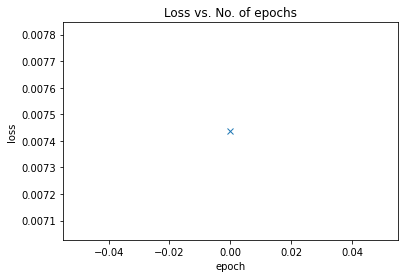

In [20]:
def plot_losses(history):
    losses = [x for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

Checking unseen data from https://www.bgc-jena.mpg.de/wetter/weather_data.html,
For that We have to feed the model past 120 days of data gets its output and compare it with 121st day and plot the same



In [78]:
dataset_url = "https://github.com/amandatta16/WeatherPrediction/blob/main/Dataset/single_2021.csv.zip?raw=true"
download_url(dataset_url, './data','single_2021.csv.zip' )
zip_file = ZipFile('./data/single_2021.csv.zip')
zip_file.extractall()
df = pd.read_csv('./data/single_2021.csv.zip', encoding = "ISO-8859-1")
df.head()
print(df.shape[0])

Using downloaded and verified file: ./data/single_2021.csv.zip
5387


In [79]:
input_features = []
for i in od:
  if i != "T (degC)":
    input_features.append(i)
features = df[input_features]
output = df[["T (degC)"]]
output.index = df["Date Time"]
features.index = df["Date Time"]
print(features.head())
print(output.head())

                     p (mbar)  VPmax (mbar)  ...  rho (g/m**3)  wv (m/s)
Date Time                                    ...                        
01.01.2021 00:10:00    978.24          7.06  ...       1235.72      1.02
01.01.2021 00:20:00    978.24          7.04  ...       1235.93      1.56
01.01.2021 00:30:00    978.26          7.00  ...       1236.34      2.08
01.01.2021 00:40:00    978.25          6.95  ...       1236.77      2.63
01.01.2021 00:50:00    978.26          6.87  ...       1237.43      2.16

[5 rows x 6 columns]
                     T (degC)
Date Time                    
01.01.2021 00:10:00      2.01
01.01.2021 00:20:00      1.96
01.01.2021 00:30:00      1.88
01.01.2021 00:40:00      1.78
01.01.2021 00:50:00      1.62


In [80]:
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
features = scaler1.fit_transform(features.values)
output = scaler2.fit_transform(output.values)
print(features)
print("################")
print(output)

[[0.39257813 0.34316354 0.17466667 0.31046931 0.44955563 0.07314974]
 [0.39257813 0.34137623 0.16933333 0.31227437 0.45128374 0.11962134]
 [0.39313616 0.33780161 0.16266667 0.31407942 0.45465767 0.16437177]
 ...
 [0.35686384 0.07774799 0.04266667 0.08483755 0.72374918 0.13769363]
 [0.35881696 0.0795353  0.044      0.08483755 0.7225971  0.16523236]
 [0.35993304 0.08221626 0.04533333 0.0866426  0.7189763  0.25301205]]
################
[[0.50168027]
 [0.49927988]
 [0.49543927]
 ...
 [0.14786366]
 [0.15026404]
 [0.15506481]]


In [81]:
model.load_state_dict(torch.load('./state_dict.pt'))
predict_dataset = TimeseriesDataset(features, output, xSequenceLength, ySequenceLength)
predict_loader = DataLoader(predict_dataset, shuffle=False, batch_size=batch_size, drop_last=True)

predicted = []
actuals = []
h = model.init_hidden(batch_size)
for inputs, actual in predict_loader:
    h = tuple([e.data for e in h])
    output, h = model(inputs, h)
    predicted.append(output.detach().numpy())
    actuals.append(actual.detach().numpy())



len(self.X) = 5387 index = 0 | index : 0  +  self.xSequenceLength : 576  =  576 | len(self.y) = 5387 (index+self.ySequenceLength-1) | index : 0  +  self.ySequenceLength-1 : 719  =  719
len(self.X) = 5387 index = 1 | index : 1  +  self.xSequenceLength : 576  =  577 | len(self.y) = 5387 (index+self.ySequenceLength-1) | index : 1  +  self.ySequenceLength-1 : 719  =  720
len(self.X) = 5387 index = 2 | index : 2  +  self.xSequenceLength : 576  =  578 | len(self.y) = 5387 (index+self.ySequenceLength-1) | index : 2  +  self.ySequenceLength-1 : 719  =  721
len(self.X) = 5387 index = 3 | index : 3  +  self.xSequenceLength : 576  =  579 | len(self.y) = 5387 (index+self.ySequenceLength-1) | index : 3  +  self.ySequenceLength-1 : 719  =  722
len(self.X) = 5387 index = 4 | index : 4  +  self.xSequenceLength : 576  =  580 | len(self.y) = 5387 (index+self.ySequenceLength-1) | index : 4  +  self.ySequenceLength-1 : 719  =  723
len(self.X) = 5387 index = 5 | index : 5  +  self.xSequenceLength : 576  = 

In [87]:
print(len(predicted))
x1 = predicted[0]
print(x1.shape)
x1 = x1.reshape(-1,1)
print(x1.shape)
x2 = (actuals[0])
print(x2.shape)





18
(256,)
(256, 1)
(256, 1)


In [88]:
x1 = scaler2.inverse_transform(x1)
x2 = scaler2.inverse_transform(x2)

In [89]:
for x in range(len(x1)):
  print("Actual = ", x2[x], " and predicted =", x1[x])

Actual =  [0.2]  and predicted = [1.9261172]
Actual =  [0.18]  and predicted = [2.216483]
Actual =  [0.17]  and predicted = [1.5766639]
Actual =  [0.19]  and predicted = [2.493634]
Actual =  [0.3]  and predicted = [1.6638689]
Actual =  [0.18]  and predicted = [2.0599058]
Actual =  [0.1]  and predicted = [1.6311251]
Actual =  [0.1]  and predicted = [2.074632]
Actual =  [0.14]  and predicted = [2.0215116]
Actual =  [0.25]  and predicted = [2.265802]
Actual =  [0.28]  and predicted = [1.758247]
Actual =  [0.32]  and predicted = [2.2215004]
Actual =  [0.28]  and predicted = [1.8382057]
Actual =  [0.28]  and predicted = [2.1638794]
Actual =  [0.29]  and predicted = [2.1361365]
Actual =  [0.35]  and predicted = [2.2889569]
Actual =  [0.42]  and predicted = [1.7689357]
Actual =  [0.4]  and predicted = [2.143906]
Actual =  [0.38]  and predicted = [2.0235503]
Actual =  [0.37]  and predicted = [2.001336]
Actual =  [0.3]  and predicted = [2.238686]
Actual =  [0.34]  and predicted = [1.9625708]
Ac